In [1]:
import json
import re
import hdbscan
from sentence_transformers import SentenceTransformer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

In [2]:
with open("../data/google_reviews.json", "r", encoding="utf-8") as f:
    data = json.load(f)

In [3]:
df_data = pd.DataFrame(data)
df_data = df_data[['review_text', 'rating', 'date']]  # ambil kolom penting
df_data.head()

,review_text,rating,date
0,Kursi dan beberapa permainan perlu diberikan p...,2 stars,3 months ago
1,Tempatnya sangat ramai ketika di hari libur se...,5 stars,2 weeks ago
2,Alun-alun Lumajang dengan fasilitas yang relat...,5 stars,3 weeks ago
3,"Alun alun lumajang,dengan semua fasilitas yang...",5 stars,a week ago
4,"First time nyobain ke Alun alun lumajang Gara""...",4 stars,5 months ago


In [4]:
with open("../data/combined_stop_words.txt", "r", encoding="utf-8") as f:
    custom_stopwords = f.read().splitlines()

In [5]:
df = pd.read_csv("../data/colloquial-indonesian-lexicon.csv")

# Ubah jadi dictionary: {"slang": "formal"}
custom_slang = dict(zip(df['slang'], df['formal']))

#Fungsi normalisasi slang
def normalize_slang(text):
    words = text.split()
    normalized = [custom_slang.get(w.lower(), w) for w in words]
    
    return " ".join(normalized)

In [6]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Stopwords Sastrawi
factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()

# Stemmer & Stopword
stemmer = StemmerFactory().create_stemmer()

# Tambahkan stopwords custom
general_words={
'alun',
'lumajang',
'kota',
'taman'
# "bagus", "banget", "indah", "cukup",
#     "enak", "mantap", "oke", "lumayan"
}

stopwords.extend(custom_stopwords)
stopwords.extend(general_words)
stopwords.append("nya")

def remove_stopwords(tokens):
    return [w for w in tokens if w not in stopwords]



In [7]:
def normalize_domain(text):
    domain_map = {
        r'\bcar\s*free\s*day\b': 'car_free_day',
        r'\bcfd\b': 'car_free_day',

        r'\barea\s*bermain\b': 'playground',
        r'\btaman\s*bermain\b': 'playground',
        r'\bmainan\s*anak\b': 'playground',

        r'\bjoging\b': 'jogging',
        r'\bjogging\s*track\b': 'jogging',
        r'\bjalan\s*santai\b': 'jogging',
        r'\blari\b': 'jogging'
    }

    for pattern, replacement in domain_map.items():
        text = re.sub(pattern, replacement, text)

    return text


In [ ]:
def tfidf_preprocess(text):
    text = text.lower()
    text = text.replace("-", " ")

    # remove URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # keep alphabet only
    text = re.sub(r'[^a-z\s]', ' ', text)

    # slang normalization (custom)
    text = normalize_slang(text)
    
    text = normalize_domain(text)

    tokens = text.split()
    
    PROTECTED_WORDS = {
        'santai', 'bersantai',
        # 'ramai', 'pantai',
        # 'asri', 'nyaman', 
    }

    # tokens = [t if t in PROTECTED_WORDS else stem
    # mer.stem(t) for t in tokens ]

    # # stemming (Sastrawi per token)
    # tokens = [stemmer.stem(t) for t in tokens if len(t) > 2]
    
    # stopword removal (custom, jangan hapus negasi)
    tokens = remove_stopwords(tokens)


    return " ".join(tokens)


In [9]:
import re

def preprocess_indobert(text):
    # 1. lowercase (aman untuk IndoBERT)
    text = text.lower()

    # 2. normalisasi tanda hubung
    text = text.replace("-", " ")

    # 3. hapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # 4. hapus emoji
    text = re.sub(
        "["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        "]+",
        "",
        text
    )

    # 5. hapus karakter aneh (tapi JANGAN hapus kata)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)

    # 6. normalisasi slang (PENTING)
    text = normalize_slang(text)

    # 7. rapikan spasi
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [10]:
df_data['indobert_clean'] = df_data['review_text'].apply(preprocess_indobert)

In [11]:
df_data['clean_text'] = df_data['review_text'].apply(tfidf_preprocess)

In [12]:
from langdetect import detect

def detect_lang(text):
    try:
        return detect(text)
    except:
        return "unknown"

df_data["lang"] = df_data["indobert_clean"].astype(str).apply(detect_lang)


In [53]:
df_data.loc[df_data["lang"] != "id",'review_text'].iloc[0]

'A city square. A place to gather. Central to activities for this small town.\nThe facilities have been upgraded over time to cater different age needs (there are playgrounds for small ones, therapy park for eldery, stage for performance and jogging paths for everyone)'

In [14]:
df_new = (
    df_data
    .loc[df_data["lang"] != "en"]
    .copy()
    .reset_index(drop=True)
)


In [15]:
df_new.reset_index(drop=True, inplace=True)

In [16]:
# Visualisasi WordCloud
all_text = ' '.join(df_new['clean_text'].astype(str))
tokens = re.findall(r'\b\w+\b', all_text.lower())

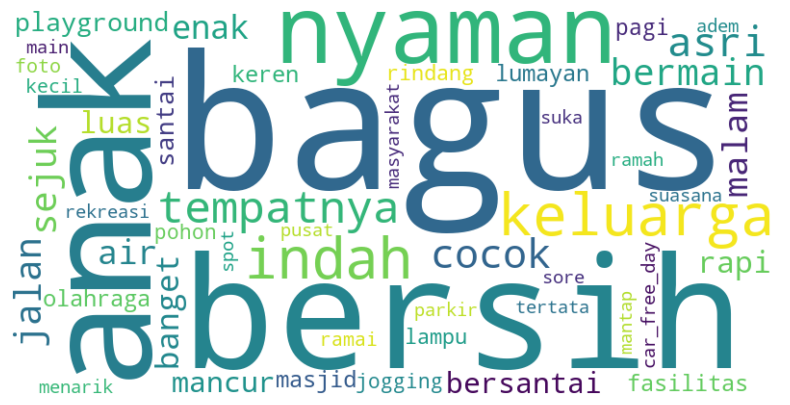

In [17]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Hitung frekuensi kata dan ambil 50 kata yang paling sering muncul
token_counts = Counter(tokens)
top_100 = token_counts.most_common(50)

# Membuat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate_from_frequencies(dict(top_100))

# Menampilkan WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [18]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('indobenchmark/indobert-base-p1')
embeddings = model.encode(df_new['indobert_clean'].tolist())


No sentence-transformers model found with name indobenchmark/indobert-base-p1. Creating a new one with mean pooling.


In [19]:
from sklearn.cluster import AgglomerativeClustering,KMeans
from sentence_transformers import SentenceTransformer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA

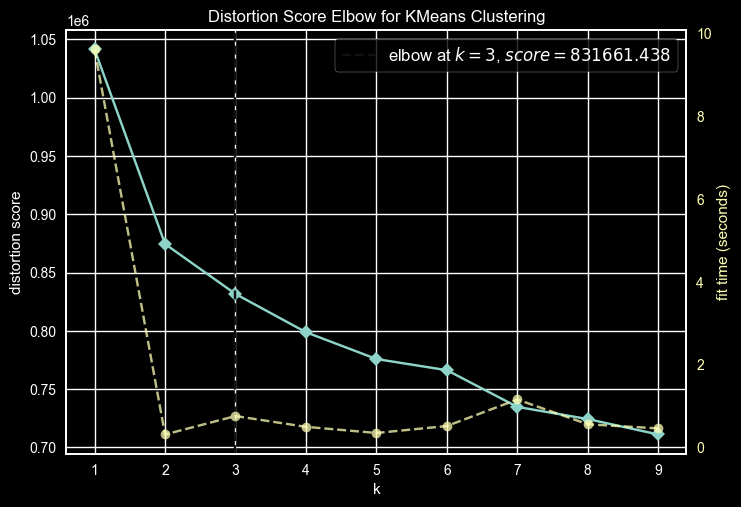

In [20]:
plt.style.use('dark_background')
kmeans = KMeans(init='k-means++', random_state=44)
visualizer = KElbowVisualizer(kmeans, k=(1,10))
visualizer.fit(embeddings)
visualizer.show()
plt.show()

In [21]:
# Perform clustering based on sentence embeddings KMeans
KMeansModel = KMeans(n_clusters=3,random_state=44)
y = KMeansModel.fit_predict(embeddings)
print('KMeansModel centers are : ' , KMeansModel.cluster_centers_)
print('KMeansModel labels are : ' , KMeansModel.labels_)
print('KMeansModel intertia is : ' , KMeansModel.inertia_)
print('KMeansModel No. of iteration is : ' , KMeansModel.n_iter_)

KMeansModel centers are :  [[-0.15180053  0.9157018   0.78130025 ...  1.534783   -0.46396136
   0.429603  ]
 [ 0.18312448  0.7704672   0.23120734 ...  1.5338336  -0.5433173
   0.69366974]
 [ 0.2528317   0.635697   -0.26584205 ...  0.7466091  -0.72727704
   0.5012363 ]]
KMeansModel labels are :  [2 2 2 ... 0 0 0]
KMeansModel intertia is :  831660.9375
KMeansModel No. of iteration is :  32


In [22]:
from sklearn.metrics import silhouette_score

score = silhouette_score(embeddings, y)
print("Silhouette Score:", score)

Silhouette Score: 0.11134225130081177


In [23]:
df_new['kmeans_cluster']=KMeansModel.labels_

In [24]:
df_new.columns

Index(['review_text', 'rating', 'date', 'indobert_clean', 'clean_text', 'lang',
       'kmeans_cluster'],
      dtype='object')

In [25]:
# Display clusters
clustered_sentences = {}
for sentence_id, cluster_id in enumerate(y):
    if cluster_id not in clustered_sentences:
        clustered_sentences[cluster_id] = []
    clustered_sentences[cluster_id].append(df_new['review_text'][sentence_id])

for cluster_id, sentence_list in clustered_sentences.items():
    print(f"\nCluster {cluster_id}: {sentence_list}\n")
    print('*'*80)


Cluster 2: ['Kursi dan beberapa permainan perlu diberikan perawatan\nPerawatan fasilitas sangat kurang terjaga\nTempat sampah banyak yg tidak ada tutupnya jadi membuat bau tidak sedap', 'Tempatnya sangat ramai ketika di hari libur sekolah dan juga banyak kuliner berserta wahana mainan anak', 'Alun-alun Lumajang dengan fasilitas yang relatif lengkap. Spot olah raga, play ground, food court hampir di sekeliling jalan di alun-alun. Pada saat CFD mungkin perlu pembenahan dan penataan pedagang, namun untuk saat ini relatif rapi. Hanya lalu lalang kendaraan yang harus dikontrol dengan ketat.', 'Alun alun lumajang,dengan semua fasilitas yang memadai,tempat yang nyaman,untuk bersama keluarga, taman yang indah, dengan perubahan yang sekrang dengan tempat duduk di pinggir jalan yang bagus dan tertata rapih', 'First time nyobain ke Alun alun lumajang Gara" deket banget ternyata sama tempat penginepan ( B syariah) .\nSabtu check in, minggu paginya bisa banget jalan" santai lanjut buat cari …', 'T

In [26]:
from collections import defaultdict

cluster_docs = defaultdict(list)

for _, row in df_new.iterrows():
    cid = row['kmeans_cluster']
    text = row['clean_text']
    cluster_docs[cid].append(text)

cluster_texts = [" ".join(docs) for docs in cluster_docs.values()]
cluster_labels = list(cluster_docs.keys())


In [27]:
print(type(df_new["clean_text"].iloc[0]))
print(df_new["clean_text"].iloc[0])


<class 'str'>
kursi permainan diberikan perawatan perawatan fasilitas terjaga sampah tutupnya membuat bau sedap


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    preprocessor=tfidf_preprocess,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.8
)

X_tfidf = vectorizer.fit_transform(df_new["review_text"])
feature_names = vectorizer.get_feature_names_out()


In [29]:
import numpy as np

def get_top_terms_per_cluster(X, labels, feature_names, top_n=10):
    clusters = np.unique(labels)
    topic_terms = {}

    for c in clusters:
        idx = np.where(labels == c)[0]
        cluster_tfidf = X[idx].mean(axis=0)

        scores = np.asarray(cluster_tfidf).flatten()
        top_idx = scores.argsort()[::-1][:top_n]

        topic_terms[c] = [(feature_names[i], scores[i]) for i in top_idx]

    return topic_terms


In [30]:
topics = get_top_terms_per_cluster(
    X_tfidf,
    df_new["kmeans_cluster"].values,
    feature_names,
    top_n=8
)

for cluster, terms in topics.items():
    print(f"\nCluster {cluster}")
    for term, score in terms:
        print(f"  {term} ({score:.4f})")



Cluster 0
  bagus (0.1926)
  mantap (0.0458)
  keren (0.0395)
  indah (0.0254)
  bersih (0.0253)
  lumayan (0.0216)
  nyaman (0.0206)
  banget (0.0197)

Cluster 1
  bagus (0.0986)
  bersih (0.0957)
  nyaman (0.0781)
  indah (0.0566)
  asri (0.0458)
  tempatnya (0.0441)
  rapi (0.0268)
  bagus bersih (0.0249)

Cluster 2
  anak (0.0441)
  bagus (0.0426)
  keluarga (0.0354)
  nyaman (0.0295)
  bersih (0.0274)
  cocok (0.0272)
  jalan (0.0225)
  indah (0.0223)


In [31]:
# d

## LDA

In [32]:
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

In [33]:
import re
import pandas as pd
import numpy as np

from gensim import corpora, models
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser

import matplotlib.pyplot as plt


In [34]:
texts = df_new['clean_text'].str.split().tolist()


In [35]:
bigram = Phrases(
    texts,
    min_count=5,
    threshold=10
)

bigram_mod = Phraser(bigram)

texts_bigram = [bigram_mod[t] for t in texts]


In [36]:
dictionary = corpora.Dictionary(texts_bigram)

# filter kata terlalu jarang & terlalu umum
dictionary.filter_extremes(
    no_below=5,   # muncul minimal di 5 dokumen
    no_above=0.5 # muncul di max 50% dokumen
)

corpus = [dictionary.doc2bow(text) for text in texts_bigram]


In [37]:
print("Jumlah dokumen:", len(corpus))
print("Jumlah vocab:", len(dictionary))


Jumlah dokumen: 4744
Jumlah vocab: 620


In [38]:
lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=5,
    random_state=42,
    chunksize=100,
    passes=10,
    alpha='auto',
    eta='auto',
    per_word_topics=True
)


In [39]:
for idx, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {idx}:")
    print(topic)
    print("="*50)


Topic 0:
0.140*"keren" + 0.101*"tempatnya" + 0.070*"good" + 0.056*"oke" + 0.033*"terbaik" + 0.033*"cantik" + 0.029*"menarik" + 0.025*"kabupaten" + 0.023*"asyik" + 0.022*"atib_berseri"
Topic 1:
0.259*"bagus" + 0.134*"bersih" + 0.125*"indah" + 0.091*"nyaman" + 0.034*"rapi" + 0.024*"sejuk" + 0.020*"keluarga" + 0.016*"cocok" + 0.015*"anak" + 0.015*"rindang"
Topic 2:
0.068*"mantab" + 0.066*"adem" + 0.057*"enak" + 0.051*"nice_place" + 0.050*"rame" + 0.035*"ku" + 0.032*"nice" + 0.027*"nongkrong" + 0.026*"tenang" + 0.024*"senang"
Topic 3:
0.233*"asri" + 0.135*"mantap" + 0.076*"banget" + 0.045*"luas" + 0.037*"suka" + 0.024*"hijau" + 0.020*"sip" + 0.017*"kebanggaan" + 0.017*"alunnya" + 0.017*"beautiful"
Topic 4:
0.142*"lumayan" + 0.056*"kenangan" + 0.056*"pusat" + 0.042*"sepi" + 0.040*"mantul" + 0.034*"asik" + 0.033*"wisata" + 0.028*"sarana" + 0.023*"seru" + 0.021*"warga"


In [40]:
coherence_model = CoherenceModel(
    model=lda_model,
    texts=texts_bigram,
    dictionary=dictionary,
    coherence='c_v'
)

coherence_score = coherence_model.get_coherence()
print("Coherence Score:", coherence_score)


Coherence Score: 0.5570510089024268


In [41]:
perplexity = lda_model.log_perplexity(corpus)
print("Perplexity:", perplexity)


Perplexity: -6.185915719089817


In [42]:
def compute_coherence_values(dictionary, corpus, texts, start=2, limit=10, step=1):
    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        model = models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=10,
            alpha='auto',
            eta='auto'
        )
        model_list.append(model)

        coherence_model = CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_values.append(coherence_model.get_coherence())

    return model_list, coherence_values


In [43]:
model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary,
    corpus=corpus,
    texts=texts_bigram,
    start=2,
    limit=11,
    step=1
)


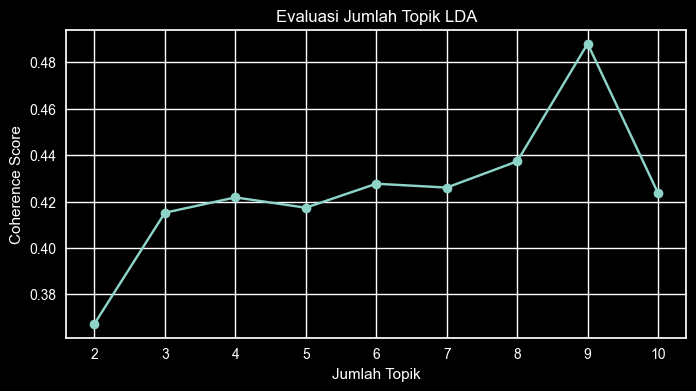

In [44]:
x = range(2, 11)

plt.figure(figsize=(8,4))
plt.plot(x, coherence_values, marker='o')
plt.xlabel("Jumlah Topik")
plt.ylabel("Coherence Score")
plt.title("Evaluasi Jumlah Topik LDA")
plt.show()


In [45]:
def get_dominant_topic(lda_model, corpus):
    dominant_topics = []

    for doc in corpus:
        topic_probs = lda_model.get_document_topics(doc)
        dominant_topic = max(topic_probs, key=lambda x: x[1])[0]
        dominant_topics.append(dominant_topic)

    return dominant_topics

df_new['dominant_topic'] = get_dominant_topic(lda_model, corpus)


In [50]:
for topic in sorted(df_new['dominant_topic'].unique()):
    print(f"\nTOPIC {topic}")
    print("-"*40)
    sample = df_new[df_new['dominant_topic'] == topic].iloc[0]
    print(sample['review_text'])



TOPIC 0
----------------------------------------
Ini aga beda bukan diusir satpol pp tapi diusir pedagang yg jualan di trotoar yang emng ditujukan untuk masyrakat umum buat duduk tetapi diusir dengan alasan mau masang tikar untuk jualan karna satpol pp nya sudah pergi

TOPIC 1
----------------------------------------
Tempatnya sangat ramai ketika di hari libur sekolah dan juga banyak kuliner berserta wahana mainan anak

TOPIC 2
----------------------------------------
rame enak buat nongkrong kebanyakan kuliner mungkin dirapikan lagi untuk parkir sepeda motor dikasih lahan khusus biar ga makan jalan

TOPIC 3
----------------------------------------
Kursi dan beberapa permainan perlu diberikan perawatan
Perawatan fasilitas sangat kurang terjaga
Tempat sampah banyak yg tidak ada tutupnya jadi membuat bau tidak sedap

TOPIC 4
----------------------------------------
Nah ini tempat favorit semua orang yang ada di Lumajang pokoknya itu tempatnya enak banget lu tengah-tengah kota Lumajang d

In [51]:
for idx, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {idx}:")
    print(topic)
    print("="*50)

Topic 0:
0.140*"keren" + 0.101*"tempatnya" + 0.070*"good" + 0.056*"oke" + 0.033*"terbaik" + 0.033*"cantik" + 0.029*"menarik" + 0.025*"kabupaten" + 0.023*"asyik" + 0.022*"atib_berseri"
Topic 1:
0.259*"bagus" + 0.134*"bersih" + 0.125*"indah" + 0.091*"nyaman" + 0.034*"rapi" + 0.024*"sejuk" + 0.020*"keluarga" + 0.016*"cocok" + 0.015*"anak" + 0.015*"rindang"
Topic 2:
0.068*"mantab" + 0.066*"adem" + 0.057*"enak" + 0.051*"nice_place" + 0.050*"rame" + 0.035*"ku" + 0.032*"nice" + 0.027*"nongkrong" + 0.026*"tenang" + 0.024*"senang"
Topic 3:
0.233*"asri" + 0.135*"mantap" + 0.076*"banget" + 0.045*"luas" + 0.037*"suka" + 0.024*"hijau" + 0.020*"sip" + 0.017*"kebanggaan" + 0.017*"alunnya" + 0.017*"beautiful"
Topic 4:
0.142*"lumayan" + 0.056*"kenangan" + 0.056*"pusat" + 0.042*"sepi" + 0.040*"mantul" + 0.034*"asik" + 0.033*"wisata" + 0.028*"sarana" + 0.023*"seru" + 0.021*"warga"
